In [1]:
#reproduction of code from https://github.com/YvesMSaintDrenan/WT_PowerCurveModel/tree/master

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams['figure.figsize'] = (10, 5)
import pandas as pd
import math as m

Here it is possible to add steps of beta from dataset
adding formulas from latex to explain code.

In [14]:
"""DATA17 = "data/raw/Onsite-MetMast-SCADA-data-2017.xlsx"
DATAScada17 = "data/raw/Wind-Turbine-SCADA-signals-2017_0.xlsx"
DATAFailures17 = "data/raw/opendata-wind-failures-2017.xlsx"""

#data from 2016
DATA = "data/raw/Onsite-MetMast-SCADA-data-2016.xlsx"
DATAScada = "data/raw/Wind-Turbine-SCADA-signals-2016.xlsx"
DATAFailures = "data/raw/Historical-Failure-Logbook-2016.xlsx"

data = pd.read_excel(DATA, engine='openpyxl')
"""data17 = pd.read_excel(DATA17, engine='openpyxl')"""

datascada = pd.read_excel(DATAScada, engine='openpyxl')
"""datascada17= pd.read_excel(DATAScada17, engine="openpyxl")"""

datafailures = pd.read_excel(DATAFailures, engine="openpyxl")

merged_df = pd.merge(datascada, data, on="Timestamp", how="inner")

In [41]:
#only looking at t07 or specified turbine
merged_df = merged_df[merged_df["Turbine_ID"] == "T07"]
merged_df

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Anemometer2_CorrGain,Anemometer2_CorrOffset,DistanceAirPress,AirRessureSensorZeroOffset,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq,airdensity,p_wind,cp_actual
3,T07,2016-01-08T23:10:00+00:00,1654.7,1247.6,1480.6,106.6,46,71,71,70,...,1,0,0,600,164,166,406,1.203715,1313.352860,79.720388
5,T07,2016-04-19T12:20:00+00:00,1766.4,1591.8,1681.7,26.1,66,124,122,118,...,1,0,0,600,258,259,405,1.206663,7862.501976,42.334616
11,T07,2016-04-19T12:30:00+00:00,1777.7,1562.6,1675.3,31.3,67,124,123,118,...,1,0,0,600,187,188,405,1.206663,6969.940919,46.338269
12,T07,2016-01-08T23:50:00+00:00,1667.5,1277.4,1481.3,119.1,46,73,72,71,...,1,0,0,600,157,158,405,1.202518,1427.752320,80.492953
16,T07,2016-04-19T12:40:00+00:00,1749.1,1585.4,1667.3,27.0,67,123,122,117,...,1,0,0,600,160,160,405,1.210836,4851.993937,62.475758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207878,T07,2016-07-16T04:50:00+00:00,76.4,6.8,34.5,15.4,72,98,98,98,...,1,0,0,600,327,328,407,1.180582,14533.118379,-0.292642
207883,T07,2016-07-01T11:10:00+00:00,1309.1,1213.9,1253.5,15.3,44,61,61,60,...,1,0,0,600,83,71,410,1.184099,259.599187,52.973972
207884,T07,2016-07-11T00:50:00+00:00,1680.9,1439.7,1595.4,55.5,50,74,74,73,...,1,0,0,600,142,144,407,1.168782,1833.067741,77.285196
207888,T07,2016-10-14T12:50:00+00:00,1337.3,1184.0,1262.5,20.1,42,64,64,64,...,1,0,0,600,80,80,403,1.191937,393.650426,62.585986


In [45]:
# calculate wind power column
# Calculate actual cp
R = 287.05
"""Amb_Temp_Avg, Avg_AmbientTemp"""
Arotor = 6362 #m^2

merged_df["airdensity"] = (merged_df["Avg_Pressure"]*100) / (R * (merged_df["Amb_Temp_Avg"]+273.15))

#Amb_WindSpeed_Avg

merged_df["p_wind"] = 0.5*merged_df["airdensity"]*Arotor*(merged_df["Amb_WindSpeed_Avg"]**3)/1000
merged_df["p_wind"]

merged_df["cp_actual"] =  merged_df["Prod_LatestAvg_TotActPwr"] / merged_df["p_wind"]



C:\Users\47915\AppData\Local\Temp\ipykernel_26716\948230375.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["airdensity"] = (merged_df["Avg_Pressure"]*100) / (R * (merged_df["Amb_Temp_Avg"]+273.15))
C:\Users\47915\AppData\Local\Temp\ipykernel_26716\948230375.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["p_wind"] = 0.5*merged_df["airdensity"]*Arotor*(merged_df["Amb_WindSpeed_Avg"]**3)/1000
C:\Users\47915\AppData\Local\Temp\ipykernel_26716\948230375.py:14: SettingWithCopyWarnin

In [46]:
merged_df["p_wind"]

3          1313.352860
5          7862.501976
11         6969.940919
12         1427.752320
16         4851.993937
              ...     
207878    14533.118379
207883      259.599187
207884     1833.067741
207888      393.650426
207891    16504.112898
Name: p_wind, Length: 52442, dtype: float64

In [47]:
merged_df["cp_actual"]

3         79.720388
5         42.334616
11        46.338269
12        80.492953
16        62.475758
            ...    
207878    -0.292642
207883    52.973972
207884    77.285196
207888    62.585986
207891    20.192239
Name: cp_actual, Length: 52442, dtype: float64

In [4]:
#This one may have to be modified to take in steps of beta

def CpLambdaModels(Model, TSR, Beta=[]):
    TSR = np.maximum(0.001, TSR)

    if Beta == []:                  # Run TSR as its own function outside? that way we can call it from this function
        Beta=np.zeros(TSR.shape)
    if Model == "constant":             # Optimally we dont want this one to ever happen in the model
        Cp=np.ones(TSR.shape)*0.49
    else:
        if Model=='Slootweg et al. 2003':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.73,151,0.58,0,0.002,13.2,18.4,0,-0.02,0.003
            x=2.14
        elif  Model=='Heier 2009':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.5,116,0.4,0,0,5,21,0,0.089,0.035
            x=0
        elif  Model=='Thongam et al. 2009':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.5176,116,0.4,0,0,5,21,0.006795,0.089,0.035
            x=0
        elif  Model=='De Kooning et al. 2010':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.77,151,0,0,0,13.65,18.4,0,0,0
            x=0
        elif  Model=='Ochieng et Manyonge 2014':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.5,116,0,0.4,0,5,21,0,0.08,0.035
            x=0
        elif  Model=='Dai et al. 2016':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.22,120,0.4,0,0,5,12.5,0,0.08,0.035
            x=0

        Li=1/(1/(TSR+c9*Beta)-c10/(Beta**3+1)) #Intermediate value. Think of as a correcting factor instead of full aerodynamical model, 

        # Cp value final calculation
        Cp=np.maximum(0,c1*(c2/Li-c3*Beta-c4*Li*Beta-c5*Beta**x-c6)*np.exp(-c7/Li)+c8*TSR)

    return Cp

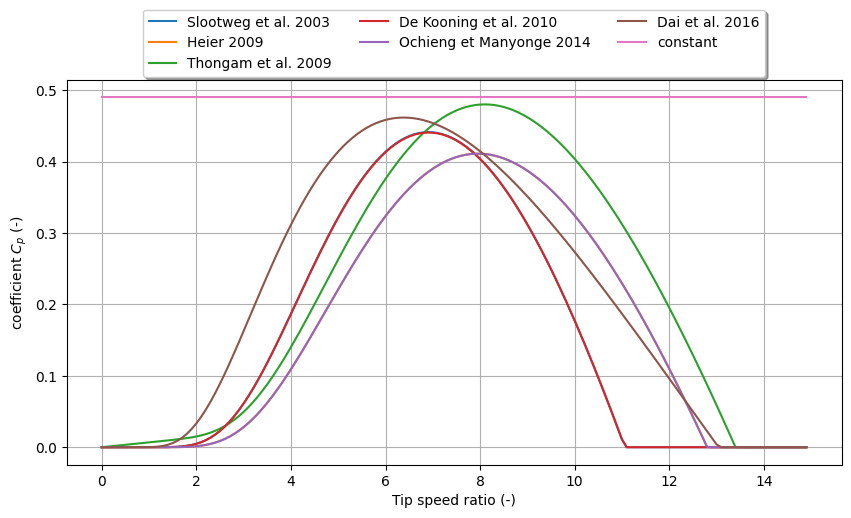

In [5]:
# Plotting
TSR=np.arange(0,15,0.1)
for Model in ['Slootweg et al. 2003','Heier 2009','Thongam et al. 2009','De Kooning et al. 2010','Ochieng et Manyonge 2014','Dai et al. 2016','constant']:
    Cp=CpLambdaModels(Model,TSR,Beta=[])
    plt.plot(TSR,Cp,label=Model)    
plt.xlabel('Tip speed ratio (-)')
plt.ylabel('coefficient $C_p$ (-)')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),fancybox=True, shadow=True, ncol=3)

In the code below, AirDensity, Beta, CpMax should come from data fed into this model

In [30]:
#make sure the correct model is selected below. This is an example

# AirDensity should be fed from data
def WT_PowerCurve_raw(Vws,Pnom,Drotor,rMin=[],rMax=[],CpMax=[],Model='Dai et al. 2016',Beta=[],AirDensity=1.225,ConvEff=0.92): #convEff is loss between measurment and the actual power
    Rrotor = Drotor/2
    Arotor = np.pi*Rrotor**2

    #This is basically a sensitivity approach, i think this can be made more clear
     # ********************************************************************************************
    # 1) Parameterisation of the minimal and maximal rotor rotational speed as a
    # function of the rotor diameter + calculation of VtipMin & VtipMax
    # source: http://publications.lib.chalmers.se/records/fulltext/179591/179591.pdf
    # ********************************************************************************************
    if rMin==[]:
        rMin=188.8*Drotor**(-0.7081)   # minimal angular speed in rpm
    if rMax==[]:
        rMax=793.7*Drotor**(-0.8504);      # maximal angular speed in rpm
    VtipMin=rMin*(2*np.pi*Rrotor)/60   # minimal tip speed in m/s
   
    VtipMax=rMax*(2*np.pi*Rrotor)/60  # maximal tip speed in m/s

        # Calculation of the optimal tip speed ratio and maximal power coefficient
    vTSR=np.arange(0,12,0.001)
    vCp=CpLambdaModels(Model,vTSR,Beta)
    TSR_Opt=np.mean(vTSR[vCp==max(vCp)])

        # ********************************************************************************************
    # 2) Calculation of the tip speed as a function of the wind speed 
    # ********************************************************************************************
    # In ths calculation step, the following assumptions are made:
    # a) the tip speed is set to maximize the energy output (*),
    #    which is achieved by setting lambda to lambdaopt, 
    # b) and assuming that Vtip is always comprised between VtipMin and VtipMax (**)
    # c) using an expression of cp as a function of lambda from (***) (no pitch control
    # assumed (**))
    # Sources:
    # (*) http://mstudioblackboard.tudelft.nl/duwind/Wind%20energy%20online%20reader/Static_pages/Cp_lamda_curve.htm
    # (**) http://www.mdpi.com/1996-1073/10/3/395
    # (***)http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6699403
    # scaling of the power coefficient function if a value is given for CpMax
    if CpMax==[]:
        CpScale=1
        CpMax=max(vCp)
    else:
        CpScale=CpMax/max(vCp)
    
    # Calculation of the tip speed and the tip speed ratio
    Vtip=np.minimum(VtipMax,np.maximum(VtipMin,TSR_Opt*Vws))
    TSR=np.zeros(Vws.shape)
    TSR[Vws>0]=Vtip[Vws>0]/Vws[Vws>0]
        
    # Calculation of the power coefficient
    Cp0=np.maximum(0,ConvEff*CpScale*CpLambdaModels(Model,TSR))

    # Calculation of the input power as a function of air density, wind speed and rotor area #FEED DATA TO THIS ONE #Pin = P_wind
    Pin=0.5*AirDensity*Arotor*(Vws**3)/1000
    Cp=np.zeros(Pin.shape)
    Cp[Pin>0]=np.minimum(Cp0[Pin>0],Pnom/Pin[Pin>0])
    Pout = Cp*Pin

    return Pout

Text(0.5, 1.0, 'Power curve calculated for a wind turbine  with a nominal \n power of 4.0 MW and a rotor diameter of 120 m \n (without consideration of environmental effects and Vcutin/Vcutout)')

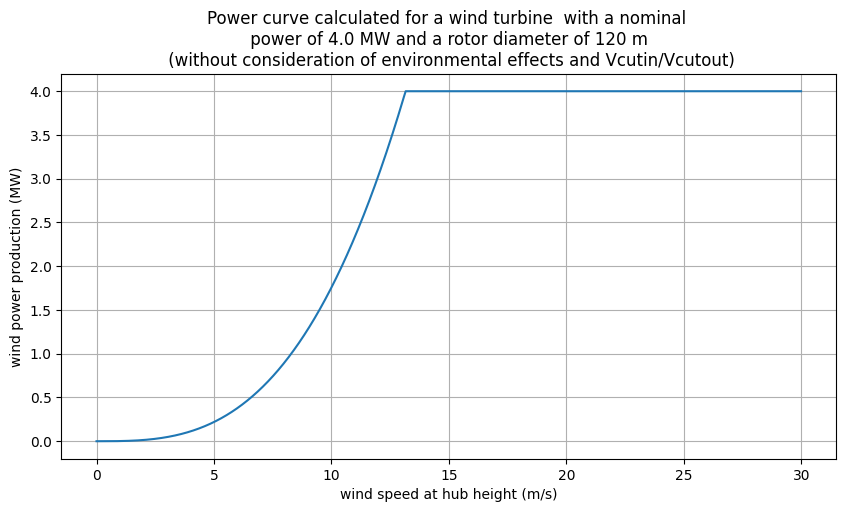

In [31]:
rMin    = 4
rMax    = 13
Drotor  = 120
Pnom    = 4000
Vws     = np.arange(0,30,0.01)

Pwt=WT_PowerCurve_raw(Vws,Pnom,Drotor,rMin=[],rMax=[],CpMax=[],Model='constant',AirDensity=1.225)
plt.plot(Vws,Pwt/1000)
plt.grid()
plt.xlabel('wind speed at hub height (m/s)')
plt.ylabel('wind power production (MW)')
plt.title('Power curve calculated for a wind turbine  with a nominal \n power of {} MW and a rotor diameter of {} m \n (without consideration of environmental effects and Vcutin/Vcutout)'.format(Pnom/1000,Drotor))

In [ ]:
def calcEffectTI(Vws,Pwt,TI=0.05,Vcutin=3,Vcutoff=25):
    
    #Gaussian filter over w*(1-TI):w*(1+TI), TI being the turbulence intensity
    if TI>0:
        Pwt_ti=0*np.ones(Vws.shape)
        for iws,tWS in enumerate(Vws):
            sigma=TI*tWS
            ix=np.where((Vws>(tWS-5*sigma)) & (Vws<(tWS+5*sigma)))[0]
            weight=np.exp(-0.5*(((Vws[ix]-tWS)/sigma)**2))
            if sum(weight)>0:
                Pwt_ti[iws]=sum(Pwt[ix]*weight)/sum(weight)
    else:
        Pwt_ti=Pwt

    # Setting the power production to zero below the cut-in and above the cut-off wind speeds
    Pwt_ti[Vws<Vcutin]=0
    Pwt_ti[Vws>Vcutoff]=0
    return Pwt_ti


In [ ]:

Pwt_ti=calcEffectTI(Vws,Pwt,TI=0.05,Vcutin=3,Vcutoff=25)

plt.plot(Vws,Pwt/1000,label='power curve without consideration of the turbulence intensity')
plt.plot(Vws,Pwt_ti/1000,label='power curve with TI=5%')
plt.grid()
plt.xlabel('wind speed at hub height (m/s)')
plt.ylabel('wind power production (MW)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),fancybox=True, shadow=True, ncol=2)

In [ ]:
def calcREWS(Vws,zhub,Drotor,Shear,Veer):
    N=10000
    zi=zhub+np.linspace(-Drotor/2,Drotor/2,N)
    dz=Drotor/N
    Ai=(2*np.sqrt((Drotor/2)**2-(zi-zhub)**2))*dz
    A=np.sum(Ai)
    
    CoeffShear=(zi/zhub)**Shear
    CoeffVeer=np.cos((zi-zhub)*Veer*np.pi/180)

    REWS=np.ones(Vws.shape)*np.nan
    for ii,V in enumerate(Vws):
        Vi=V*CoeffShear*CoeffVeer
        REWS[ii]=(np.sum((Vi**3)*Ai/A))**(1/3)
    
    return REWS

In [ ]:
vShear=np.arange(0,0.6,0.1)
vVeer=np.arange(0,0.8,0.1)

Drotor = 100
zhub   = 75
Vws    = np.arange(0,30,0.01)

fig,axs=plt.subplots(1,2,figsize=(14, 5))

norm = matplotlib.colors.Normalize(vmin=min(vShear), vmax=max(vShear))
for Shear in vShear:
    rgba_color = np.array(cm.jet(norm(Shear),bytes=True))/255
    REWS=calcREWS(Vws,zhub,Drotor,Shear,Veer=0)
    axs[0].plot(Vws,REWS,label='shear={0:.2f}; veer=0°/m'.format(Shear),color=rgba_color)
axs[0].grid()
axs[0].set_xlabel('wind speed at hub height (m/s)')
axs[0].set_ylabel('Rotor equivalent wind speed \n REWS (m/s)')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),fancybox=True, shadow=True, ncol=2)

norm = matplotlib.colors.Normalize(vmin=min(vVeer), vmax=max(vVeer))
for Veer in vVeer:
    rgba_color = np.array(cm.jet(norm(Veer),bytes=True))/255
    REWS=calcREWS(Vws,zhub,Drotor,Shear=0,Veer=Veer)
    axs[1].plot(Vws,REWS,label='shear=0; veer={0:.2f}°/m'.format(Veer),color=rgba_color)

axs[1].grid()
axs[1].set_xlabel('wind speed at hub height (m/s)')
axs[1].set_ylabel('Rotor equivalent wind speed \n REWS (m/s)')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),fancybox=True, shadow=True, ncol=2)

In [ ]:
def GenericWindTurbinePowerCurve(Vws,Pnom,Drotor,zhub=[],Vcutin=3,Vcutoff=25,TI=0.1,Shear=0.15,Veer=0,rMin=[],rMax=[],CpMax=[],Model='Dai et al. 2016',Beta=[],AirDensity=1.225,ConvEff=[]):
    
    # conversion losses
    if ConvEff==[]:
        gear_loss_const= .01
        gear_loss_var= .014
        generator_loss= 0.03
        converter_loss= .03
        ConvEff=(1-gear_loss_const)*(1-gear_loss_var)*(1-generator_loss)*(1-converter_loss)
    
    # Estimation of the hub height based on a statistical relationship made using data from thewindpower.net
    if zhub==[]:
        zhub=10.95*Drotor+0.9205 
        
    # Calculation of the rotor equivalent wind speed
    REWS=calcREWS(Vws,zhub,Drotor,Shear,Veer)

    # Calculation of the power curve without consideration of the TI and cut-in and cut-off wind speeds
    Pout_raw=WT_PowerCurve_raw(REWS,Pnom,Drotor,rMin,rMax,CpMax,Model,Beta,AirDensity,ConvEff)

    # Calculation of the effect of the TI, cut-in and cut-off wind speeds on the power curve
    Pwt_ti=calcEffectTI(REWS,Pout_raw,TI,Vcutin,Vcutoff)
   
    return Pwt_ti

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 5)
import GenericWindTurbinePowerCurve as GWTPC

Pnom    = 2000
Drotor  = 80
Vws     = np.arange(0,30,0.01)

Pwt=GWTPC.GenericWindTurbinePowerCurve(Vws,Pnom,Drotor)

plt.plot(Vws,Pwt)
plt.ylabel('wind power (kW)')
plt.xlabel('wind speed (m/s)')
plt.grid()